In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from tqdm import tqdm
from joblib import dump, load
import pickle
from sklearn.metrics import *
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
import plotly.graph_objects as go
import plotly.offline as po

sys.path.append('../utils')
from eval_utils import *

data_path = '../prediction_data/'
# read in population dataframe
num_days_prediction = 90
df_pop = pd.read_csv(data_path+"population.csv")
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="%Y-%m-%d")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

test_labels = pd.read_csv('stored_data/5_21_model_test_output.csv')
df_test = pd.read_csv('stored_data/test_df_5_21.csv')

In [2]:
with open('models/xgb_8_visits_5_21.pkl', 'rb') as f:
    testing_clf = pickle.load(f)

save_cols = load('stored_data/df_all_iters_columns_8_visits_5_21')
save_cols.remove('iteration')
X_test = df_test[save_cols].values

In [7]:
top_shap_values, top_mean_shap = get_shap_values('test_df_5_21.csv', 'xgb_8_visits_5_21.pkl')

print(top_mean_shap.columns)
feat_names = ['Longest inpatient LOS', 'Longest ED LOS', 'Total time in inpatient care', 
              'Psychiatric diagnostic evaluation w/ medical services',
               'Longest psychiatric inpatient LOS','Total time in psychiatric inpatient care', 
              'Psychostimulants, agents used for ADHD and nootropics', 'Antipsychotics',
              'Oral examination',
              'ED visit, moderate complexity']

In [9]:
# gain
df_tree = testing_clf.get_booster().trees_to_dataframe() 
features_only = df_tree.loc[df_tree['Feature']!= 'Leaf']
features_arr = features_only['Feature'].values
for i in range(len(features_arr)):
    features_arr[i] = (features_arr[i][1:])
features_only['Feature'] = features_arr
features_only['Feature'] = pd.to_numeric(features_only['Feature'])

dict_feature_map = {}
for i in range(len(save_cols)):
    dict_feature_map[i] = save_cols[i]
    
features_only['Feature'].replace(dict_feature_map, inplace=True)

feature_import = features_only.groupby('Feature').mean()
top_gain = feature_import.sort_values('Gain', ascending=False)[0:10]

top_gain.index=['I95 (Hypertension, unspecified)', 'HPV screening',
                'Conditioning play audiometry', 
                'Antipsychotics', 'hCG test; quantitative', 
                'Hormones and related agents','Antiglaucoma preparations and miotics',
                'M75 (Shoulder lesions)', 'J16 (Pneumonia from other infectious organisms)', 
                'L02 (Cutaneous abscess, furuncle and carbuncle)']

top_gain.reset_index(inplace=True)

top_gain.index


/tmp/ipykernel_3473148/817140973.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3473148/817140973.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3473148/817140973.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3473148/817140973.py:16: FutureWarning:

The default v

RangeIndex(start=0, stop=10, step=1)

In [11]:
# coverage
top_coverage = feature_import.sort_values('Cover', ascending=False)[0:10]

top_coverage.index = ['I87 (Other disorders of veins)', 'Hormones and related agents',
                      'Hormones and related agents', 'J16 (Pneumonia from other infectious organisms)', 
                      'Postpartum care only (separate procedure)','Repair and refitting spectacles',
                      'Tuberculosis skin test', 'Routine obstetric care', 
                      'Ophthalmological services, established patient','Antipropulsives']
top_coverage.reset_index(inplace=True)


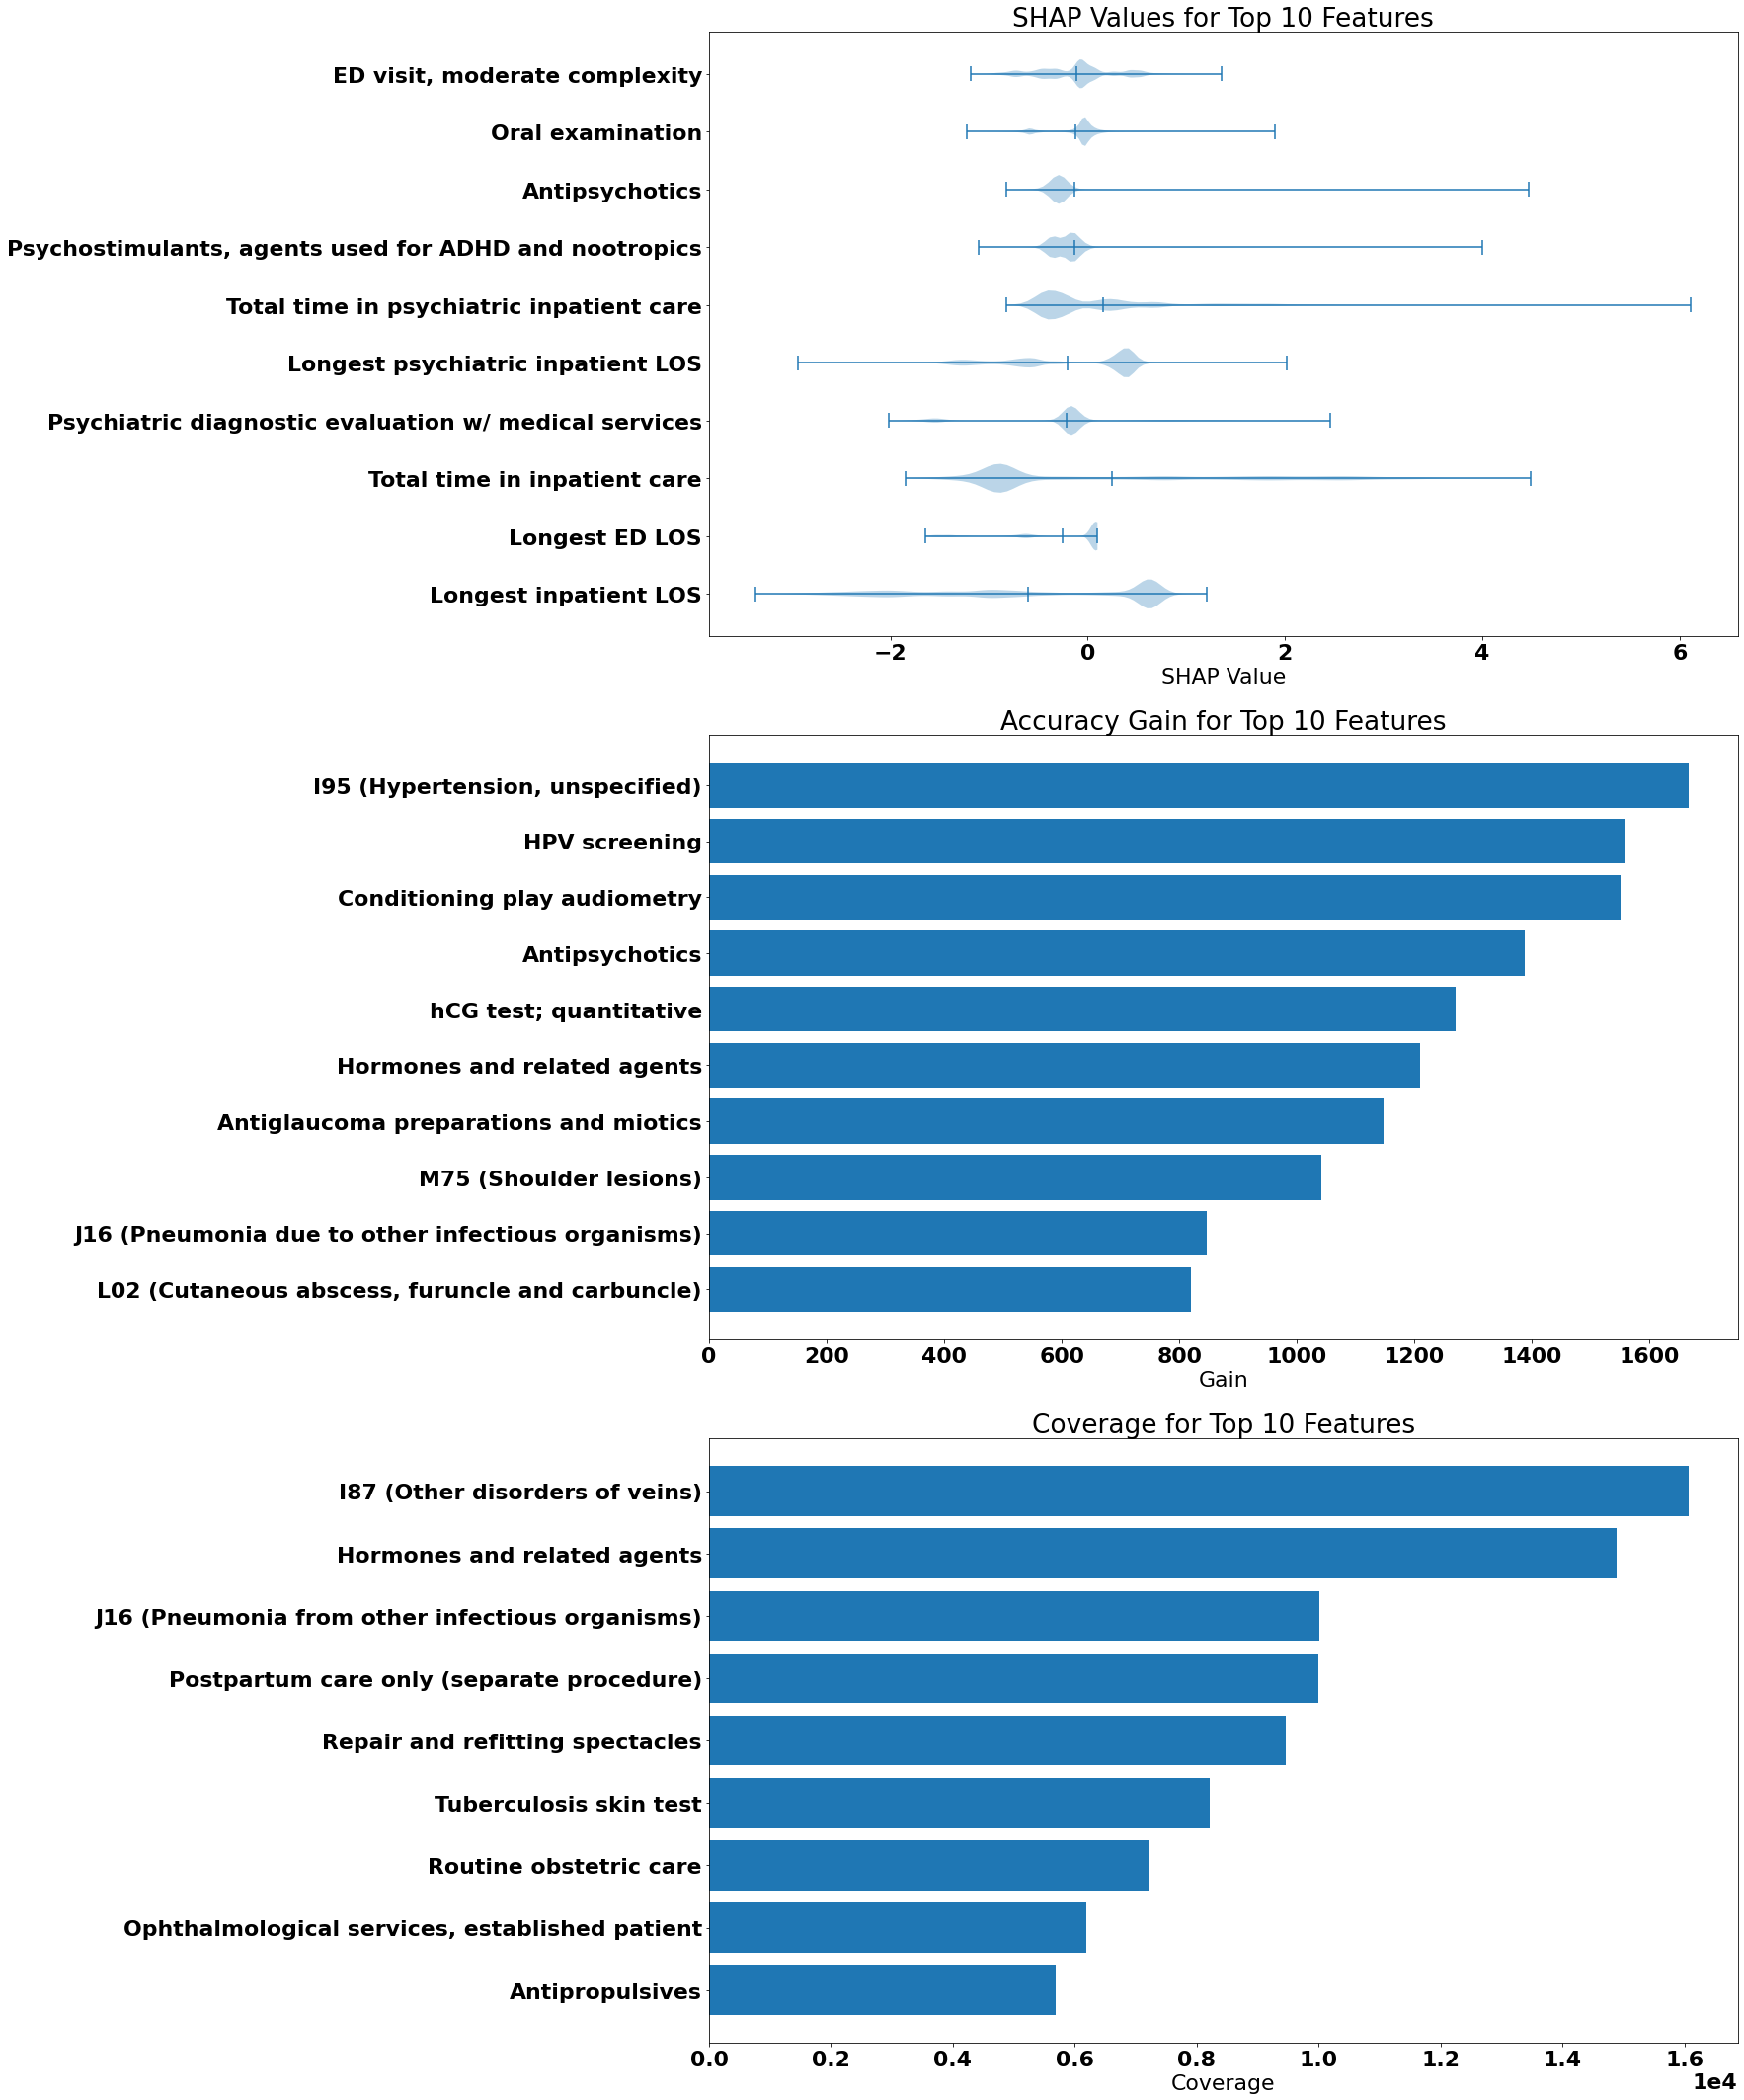

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25,30))
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

plt.subplot(3,1,1)
plt.violinplot(top_shap_values, vert=False, showmeans=True, showextrema=True)
plt.yticks(np.arange(1, len(feat_names)+1), feat_names, fontsize=22)
plt.xlabel('SHAP Value')
plt.title('SHAP Values for Top 10 Features')

matplotlib.rc('font', **font)
plt.subplot(3,1,2)
ax = axes[1]
ax.barh(top_gain['index'], top_gain['Gain'])
ax.set_title('Accuracy Gain for Top 10 Features')
ax.set_xlabel('Gain')
ax.invert_yaxis()
matplotlib.rc('font', **font)


plt.subplot(3,1,3)
ax = axes[2]
ax.barh(top_coverage['index'], top_coverage['Cover'])
ax.set_title('Coverage for Top 10 Features')
ax.set_xlabel('Coverage')
ax.invert_yaxis()
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.savefig('results/xgboost_interpretation_5_21.pdf', dpi=300)
plt.show()

## eFigure 2: Sankey Diagram

In [14]:
# Create a dictionary where the key is the node's feature and the value is all the "downstream" features
direct_dict_downstream_nodes = {}
for i in features_only['ID']:
    direct_dict_downstream_nodes[i] = features_only.loc[features_only['ID']==i, ['Yes', 'No']].values
    direct_dict_downstream_nodes[i] = list(direct_dict_downstream_nodes[i][0])

In [15]:
def get_sankey_values(layer_ids, l1, num_l1, num_l2, features_only, direct_dict_downstream_nodes):
    # for the top num_l1 most common 1st features:
    ## what are the num_l2 most common follow-up features
    l1_l2_combined = []
    for feat in l1.index[0:num_l1]:
        temp_ids = features_only.loc[(features_only['Feature']==feat) & (features_only['ID'].isin(layer_ids)), 'ID'].values
        list_arrs_feat = []
        for tid in temp_ids:
            list_arrs_feat = list_arrs_feat + (list(features_only.loc[features_only['ID'].isin(direct_dict_downstream_nodes[tid]), 'Feature'].values))
        l1_l2_combined.append(np.asarray(list_arrs_feat).reshape(-1))
    l2 = pd.Series(np.hstack(l1_l2_combined)).value_counts()[0:num_l2]
    
    # how many times do we go from each feature in l1 (most common) to l2 (most common)
    list_arrs = []
    for i in range(num_l1):
        list_arrs.append(np.repeat(i, num_l2))
    source = np.hstack(list_arrs)
    target = np.tile(np.arange(num_l1,num_l1+num_l2), num_l1)
    values = []
    for f1 in range(num_l1):
        feat1 = l1.index[f1]
        for f2 in range(num_l2):
            feat2 = l2.index[f2]
            values.append((feat2 == l1_l2_combined[f1]).sum())
    values = np.asarray(values)
    l2_labels = list(l2.index)
    
    return source, target, values, l2_labels

In [16]:
#layer 1 starts with tree-0
layer_1 = []
for i in direct_dict_downstream_nodes:
    if int(i.split('-')[1])==0:
        layer_1.append(i)
l1 = features_only.loc[features_only['ID'].isin(layer_1)]['Feature'].value_counts()

In [17]:
s12, t12, v12, l2_labels = get_sankey_values(layer_1, l1, 5, 7, features_only, direct_dict_downstream_nodes)

l2_id = features_only.loc[features_only['ID'].isin(layer_1), ['Yes', 'No']].values.reshape(-1)
l2 = features_only.loc[features_only['ID'].isin(l2_id)]['Feature'].value_counts()
s23, t23, v23, l3_labels = get_sankey_values(l2_id, l2, 7, 9, features_only, direct_dict_downstream_nodes)
s23 = s23+5
t23 = t23+5

l3_id = features_only.loc[features_only['ID'].isin(l2_id), ['Yes', 'No']].values.reshape(-1)
l3 = features_only.loc[features_only['ID'].isin(l3_id)]['Feature'].value_counts()
s34, t34, v34, l4_labels = get_sankey_values(l3_id, l3, 9, 10, features_only, direct_dict_downstream_nodes)
s34+=12
t34+=12

l4_id = features_only.loc[features_only['ID'].isin(l3_id), ['Yes', 'No']].values.reshape(-1)
l4 = features_only.loc[features_only['ID'].isin(l4_id)]['Feature'].value_counts()

In [18]:
source = np.hstack([s12, s23, s34])
target = np.hstack([t12, t23, t34])
value = np.hstack([v12, v23, v34])
labels = list(l1.index[0:5]) + l2_labels + l3_labels + l4_labels
"""
source = np.hstack([s12, s23])
target = np.hstack([t12, t23])
value = np.hstack([v12, v23])
labels = list(l1.index[0:5]) + l2_labels + l3_labels
"""

print(labels)
for i in range(len(labels)):
    labels[i] = labels[i][0:35]

['los_sum_inpatient', 'los psych sum', 'most_recent_outpatient', 'ANTIPSYCHOTICS', 'PSYCHOSTIMULANTS, AGENTS USED FOR ADHD AND NOOTROPICS', 'los_max_inpatient', 'num_visits_outpatient', 'ANTIPSYCHOTICS', 'most_recent_outpatient', 'F90', 'Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: An expanded problem focused history; An expanded problem focused examination; Medical decision making of low', 'los psych max', 'los_sum_inpatient', 'los psych max', 'Mental health assessment, by non-physician', 'los_min_inpatient', 'los psych sum', 'most_recent_ED', 'Child examination', 'Oral examination', 'R29', 'los_max_inpatient', 'los psych mean', 'los psych max', 'los_sum_inpatient', 'los psych sum', 'PSYCHOSTIMULANTS, AGENTS USED FOR ADHD AND NOOTROPICS', 'R09', 'ANTIPSYCHOTICS', 'CORTICOSTEROIDS, COMBINATIONS WITH ANTIBIOTICS', 'los_min_inpatient']


In [19]:
labels = ['Total time in inpatient care', 'Total time in psychiatric inpatient care',
          'Days since most recent outpatient visit', 'Antipsychotics',
          'Psychostimulants (used for ADHD, nootropics)', 'Longest inpatient LOS',
          'Number of outpatient visits', 'Antipsychotics',
          'Days since most recent outpatient visit', 'F90 (ADHD)',
          'Office or outpatient visit, established patient', 'Longest psychiatric inpatient LOS',
          'Total time in inpatient care', 'Longest psychiatric inpatient LOS',
          'Mental health assessment, non-physician', 'Shortest inpatient LOS',
          'Total time in psychiatric inpatient care','Days since most recent ED visit',
          'Child examination', 'Oral examination',
          'R29 (Nervous/musculoskeletal symptoms)', 'Longest inpatient LOS',
          'Mean psychiatric inpatient LOS', 'Longest psychiatric inpatient LOS',
          'Total time in inpatient care', 'Total time in psychiatric inpatient care',
          'Psychostimulants (used for ADHD, nootropics)', 'R09 (Circulatory/respiratory symptoms)',
          'Antipsychotics', 'Corticosteroids (combination w/ antibiotics)', 
          'Shortest inpatient LOS']

color = ['blue', 'blue',
         'blue', 'fuchsia',
         'fuchsia','blue',
         'blue', 'fuchsia',
         'blue', 'red',
         'green','blue',
         'blue', 'blue',
         'green','blue',
         'blue', 'blue',
         'green', 'green',
         'red', 'blue',
         'blue', 'blue',
         'blue', 'blue',
         'fuchsia', 'red',
         'fuchsia','fuchsia',
         'blue']

# red is conditions, blue is visits, green is procedures, black is labs, purple is medications

In [26]:
annotations_dictlist = []
for i in range(0, 20):
    dict_append = {'x': 0.9, 'y': i*0.2, 'text': labels[i], 'showarrow':False, 'color':color[i]}
    annotations_dictlist.append(dict_append)
    
link = dict(source = source, target = target, value = value)
node = dict(label = labels, pad=50, thickness=20, color=color)
data = go.Sankey(link = link, node=node)


layout = go.Layout(
    autosize=False,
    width=1500, height=1000,
    font_family="Helvetica",
    font_color="black")

fig = go.Figure(data, layout)

fig.update_layout(font_size=12)
fig.show()